<a href="https://colab.research.google.com/github/HSE-LAMBDA/mldm-2019/blob/master/day-9/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://github.com/yandexdataschool/MLatImperial2019/raw/master/06_lab/lfw_dataset.py

In [0]:
!pip install scipy==1.1

In [3]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [4]:
import numpy as np
import tensorflow as tf
tf.__version__

'2.0.0'

In [5]:
from lfw_dataset import fetch_lfw_dataset
data, _ = fetch_lfw_dataset(dimx=36, dimy=36)

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [6]:
data.shape

(13143, 36, 36, 3)

In [0]:
import matplotlib.pyplot as plt

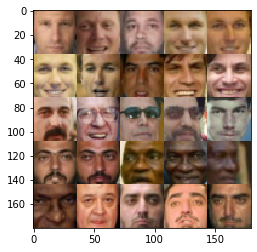

In [8]:
plt.imshow(data[:25].reshape(5, 5, 36, 36, 3).transpose((0, 2, 1, 3, 4)).reshape(5 * 36, 5 * 36, 3));

In [9]:
X_train = data.astype('float32') / 255
print(X_train.min(), X_train.max(), X_train.dtype)

0.0 1.0 float32


In [10]:
ll = tf.keras.layers

LATENT_DIM = 32

decoder = tf.keras.Sequential([
  ll.Dense(32, input_shape=(LATENT_DIM,), activation='relu'),
  ll.Dense(64, activation='relu'),
  ll.Dense(36 * 36 * 3, activation='sigmoid'),
  ll.Reshape((36, 36, 3)),
])

encoder_base = tf.keras.Sequential([
  ll.Reshape((36 * 36 * 3,), input_shape=(36, 36, 3)),
  ll.Dense(64, activation='relu'),
  ll.Dense(32, activation='relu')
])
latent_mu = ll.Dense(LATENT_DIM, activation=None)(encoder_base.output)
latent_logsigma = ll.Dense(LATENT_DIM, activation=None)(encoder_base.output)
encoder = tf.keras.Model(inputs=encoder_base.inputs, outputs=[latent_mu, latent_logsigma])

decoder.summary()
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 3888)              252720    
_________________________________________________________________
reshape (Reshape)            (None, 36, 36, 3)         0         
Total params: 255,888
Trainable params: 255,888
Non-trainable params: 0
_________________________________________________________________
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
reshape_1_input (InputLayer)    [(N

In [0]:
def gen_images(mu, logsigma):
  return decoder(tf.random.normal(shape=mu.shape) * tf.exp(logsigma) + mu)

# @tf.function decorator below compiles the function
# it decorates into a static graph. This improves the performance
# but there are some pitfalls one should be aware of when using it,
# check out https://www.tensorflow.org/tutorials/customization/performance
# for more details
@tf.function
def forward(batch):
  real = batch

  mu, logsigma = encoder(real)
  fake = gen_images(mu, logsigma)

  loss_mse = tf.reduce_sum((real - fake)**2, axis=(1, 2, 3))
  loss_KL = tf.reduce_sum(-logsigma + 0.5 * (mu**2 + tf.exp(2 * logsigma) - 1), axis=1)
  return tf.reduce_mean(loss_mse + 0.1 * loss_KL)

opt_g = tf.optimizers.Adam()

@tf.function
def gen_step(batch):
  with tf.GradientTape() as t:
    g_loss = forward(batch)
  grads = t.gradient(g_loss, encoder.trainable_variables + decoder.trainable_variables)
  opt_g.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))
  return g_loss


In [0]:
from IPython.display import clear_output
from tqdm import trange

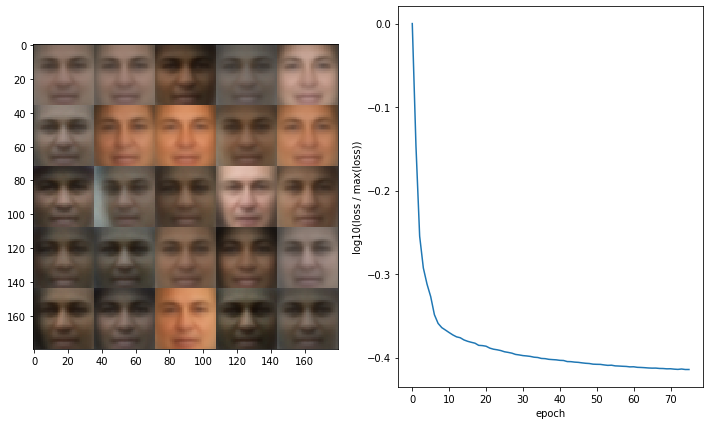

  2%|▏         | 2/103 [00:00<00:06, 16.24it/s]

Done with epoch # 75


 62%|██████▏   | 64/103 [00:03<00:02, 16.23it/s]


KeyboardInterrupt: ignored

In [23]:
BATCH_SIZE = 128

N_EPOCHS = 100

losses = []
for i_ep in range(N_EPOCHS):
  shuffle_ids = np.random.choice(len(X_train), len(X_train), replace=False)
  epoch_loss = 0
  for i_img in trange(0, len(X_train), BATCH_SIZE):
    batch = X_train[shuffle_ids][i_img:i_img + BATCH_SIZE]
    epoch_loss += gen_step(batch).numpy() * len(batch)

  epoch_loss /= len(X_train)
  losses.append(epoch_loss)

  opt_g.learning_rate.assign(opt_g.learning_rate * 0.99)

  if i_ep % 5 == 0 or i_ep == N_EPOCHS - 1:
    imgs = (gen_images(tf.zeros(shape=(25, LATENT_DIM)),
                      tf.zeros(shape=(25, LATENT_DIM))).numpy() * 255).astype('uint8')
    clear_output(wait=True)
    plt.figure(figsize=(12, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(imgs.reshape((5, 5, 36, 36, 3)).transpose(0, 2, 1, 3, 4).reshape(36 * 5, 36 * 5, 3))
    plt.subplot(1, 2, 2)
    plt.plot(np.log10(losses / max(losses)))
    plt.xlabel('epoch')
    plt.ylabel('log10(loss / max(loss))')
    plt.show()
    print("Done with epoch #", i_ep)